In [1]:
from __future__ import print_function, division, absolute_import

import GPy
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
import safeopt
import stageopt

mpl.rcParams['figure.figsize'] = (20.0, 10.0)
mpl.rcParams['font.size'] = 20
mpl.rcParams['lines.markersize'] = 20

In [2]:
# Measurement noise
noise_var0 = 0.05 ** 2
noise_var1 = 1e-5
# noise_var2 = 1e-5
# noise_var3 = 1e-5

# Bounds on the inputs variable
bounds = [(0., 1.), (0., 1.)]

# Define Kernel
kernel0 = GPy.kern.Matern32(input_dim=len(bounds), variance=2., lengthscale=1.0, ARD=True)
kernel1 = kernel0.copy()
# kernel2 = kernel0.copy()
# kernel3 = kernel0.copy()

# Initial safe point
x0 = np.zeros((1, len(bounds)))

# Generate function with safe initial point at x=0
def sample_safe_fun():
    fun_f = safeopt.sample_gp_function(kernel0, bounds, noise_var0, 25)
    while True:
        fun_s1 = safeopt.sample_gp_function(kernel1, bounds, noise_var1, 25)
        if fun_s1([0., 0.], noise=False) > 1:
            break
            
    def combined_fun(x, noise=True):
        return np.hstack([fun_f(x, noise), fun_s1(x, noise)])
    return combined_fun

In [3]:
# Define the objective function
fun = sample_safe_fun()

# The statistical model of our objective function and safety constraint
y0 = fun(x0)
gp_safe_f = GPy.models.GPRegression(x0, y0[:, 0, None], kernel0, noise_var=noise_var0)
gp_stage_f = GPy.models.GPRegression(x0, y0[:, 0, None], kernel0, noise_var=noise_var0)
gp_safe_s1 = GPy.models.GPRegression(x0, y0[:, 1, None], kernel1, noise_var=noise_var1)
gp_stage_s1 = GPy.models.GPRegression(x0, y0[:, 1, None], kernel1, noise_var=noise_var1)

# The optimization routine
# opt = safeopt.SafeOptSwarm(gp, 0., bounds=bounds, threshold=0.2)
parameter_set = safeopt.linearly_spaced_combinations(bounds, 25)
safe_opt = safeopt.SafeOpt([gp_safe_f, gp_safe_s1], parameter_set, [-np.inf, 0.], lipschitz=None, threshold=0.2)
stage_opt = stageopt.StageOpt([gp_stage_f, gp_stage_s1], parameter_set, [-np.inf, 0.], lipschitz=None, threshold=0.2, switch_time=5)

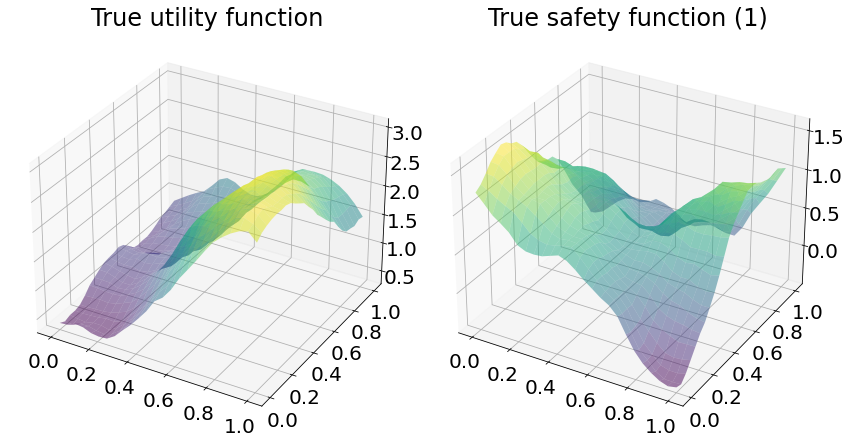

Maximum utility in the safe region: 3.06842045593703


In [4]:
# 绘制真实函数
X = np.linspace(bounds[0][0], bounds[0][1], 25)
Y = np.linspace(bounds[1][0], bounds[1][1], 25)
X, Y = np.meshgrid(X, Y)
Z = np.array([fun([x, y], noise=False).flatten() for x, y in zip(X.ravel(), Y.ravel())])

# Reshape Z for utility and safety components
Z_f = Z[:, 0].reshape(X.shape)  # Utility function
Z_s1 = Z[:, 1].reshape(X.shape)  # Safety function (1)

# 创建图形对象
fig = plt.figure(figsize=(12, 12))

# 创建 3D 子图
ax_f = fig.add_subplot(121, projection='3d')  # 1st subplot for utility function
ax_s1 = fig.add_subplot(122, projection='3d')  # 2nd subplot for safety function

# 绘制真实函数
ax_f.plot_surface(X, Y, Z_f, alpha=0.5, cmap='viridis')
ax_f.set_title("True utility function")
ax_s1.plot_surface(X, Y, Z_s1, alpha=0.5, cmap='viridis')
ax_s1.set_title("True safety function (1)")

# 显示图形
plt.tight_layout()
plt.show()

# 计算安全区域中，真实效用函数的最大值
safe_region = np.where(Z_s1 > 0)
safe_utility = Z_f[safe_region]
safe_max_utility = np.max(safe_utility)
print("Maximum utility in the safe region:", safe_max_utility)

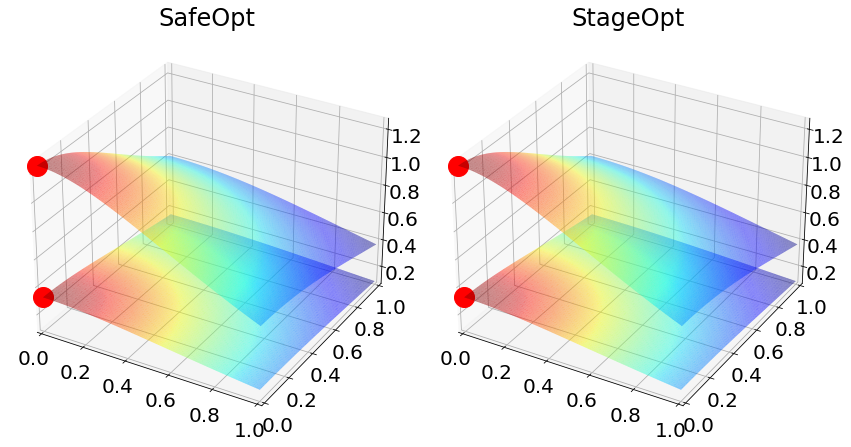

In [5]:
def plot_gp():
    # 创建图形对象
    fig = plt.figure(figsize=(12, 12))

    # 创建第一个 3D 子图
    ax1 = fig.add_subplot(121, projection='3d')  # 211 表示 2 行 1 列，第 1 个子图
    safe_opt.plot(100, axis=ax1, plot_3d=True)  # 在第一个子图上绘制
    ax1.set_title("SafeOpt")

    # 创建第二个 3D 子图
    ax2 = fig.add_subplot(122, projection='3d')  # 212 表示 2 行 1 列，第 2 个子图
    stage_opt.plot(100, axis=ax2, plot_3d=True)  # 在第二个子图上绘制
    ax2.set_title("StageOpt")

    # 显示图形
    plt.tight_layout()
    plt.show()

plot_gp()

Iteration: 1
Best reward: SafeOpt: 0.34098568938657603, StageOpt: 0.4190322786297153
Regret: SafeOpt: 2.727434766550454, StageOpt: 2.6493881773073147


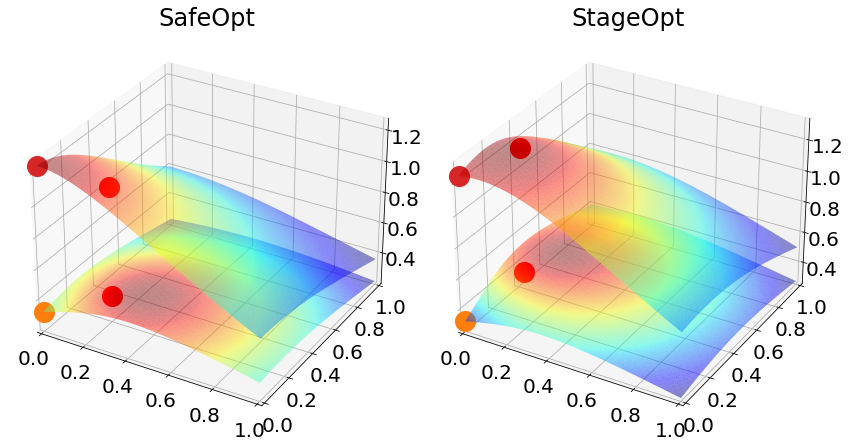

Iteration: 2
Best reward: SafeOpt: 0.6643442135038585, StageOpt: 0.5704293172222441
Regret: SafeOpt: 2.4040762424331716, StageOpt: 2.497991138714786


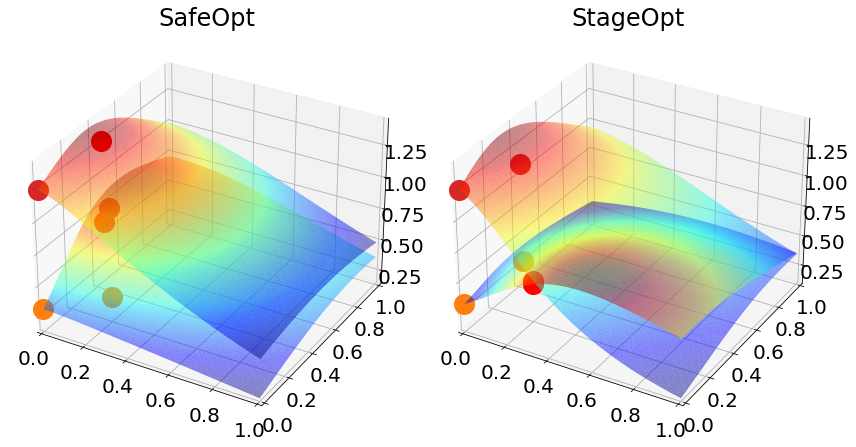

Iteration: 3
Best reward: SafeOpt: 0.664138162569541, StageOpt: 0.5944890984748324
Regret: SafeOpt: 2.404282293367489, StageOpt: 2.4739313574621975


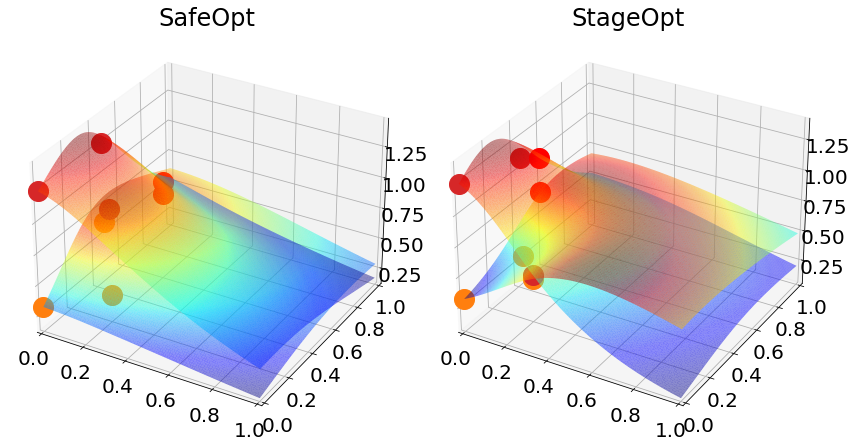

Iteration: 4
Best reward: SafeOpt: 1.7024919986136942, StageOpt: 0.8268428875492891
Regret: SafeOpt: 1.365928457323336, StageOpt: 2.241577568387741


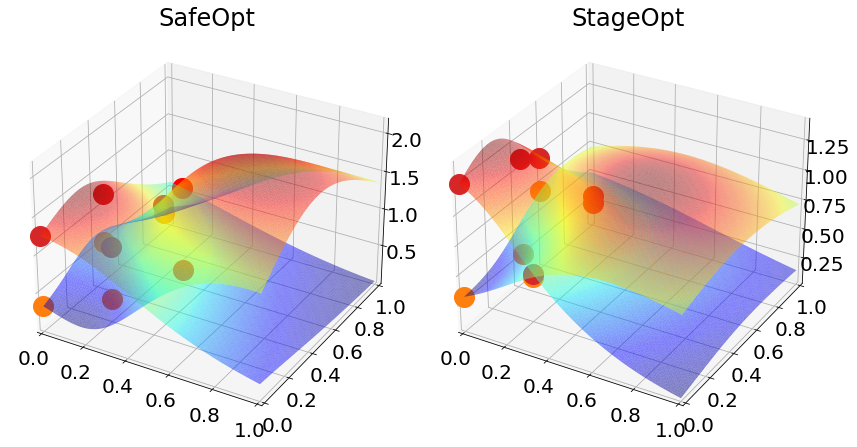

Iteration: 5
Best reward: SafeOpt: 1.6962712267865276, StageOpt: 1.059039188893289
Regret: SafeOpt: 1.3721492291505024, StageOpt: 2.009381267043741


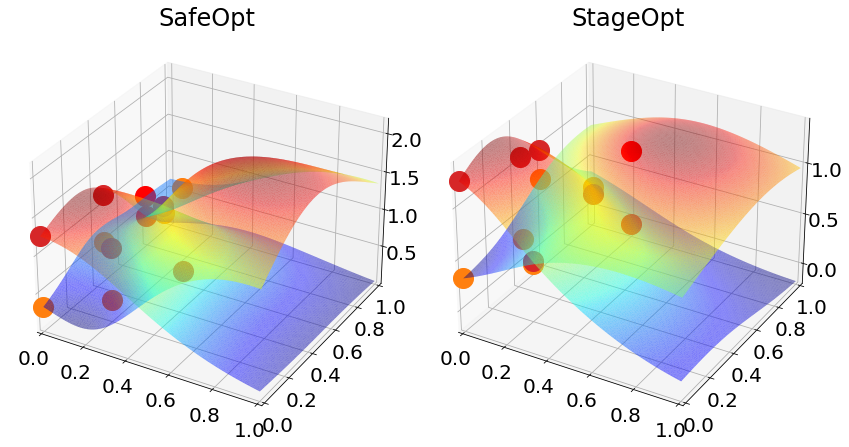

Iteration: 6
Best reward: SafeOpt: 1.7062881928632438, StageOpt: 1.8425093795259815
Regret: SafeOpt: 1.3621322630737862, StageOpt: 1.2259110764110486


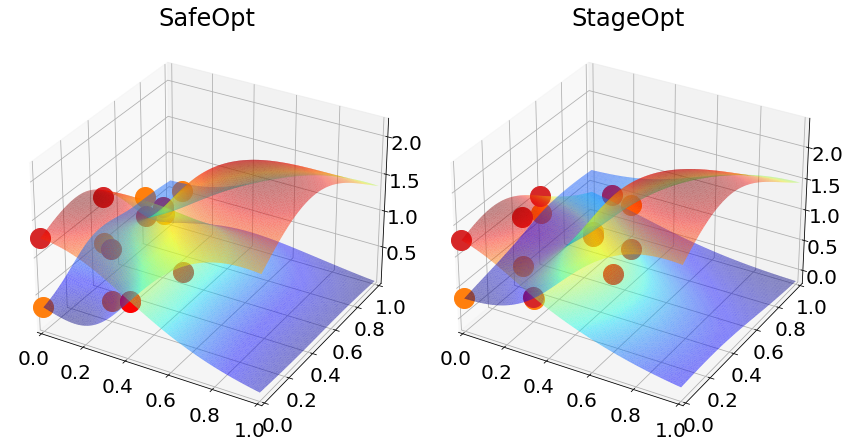

Iteration: 7
Best reward: SafeOpt: 1.7140998991878262, StageOpt: 2.4480946143673523
Regret: SafeOpt: 1.3543205567492038, StageOpt: 0.6203258415696777


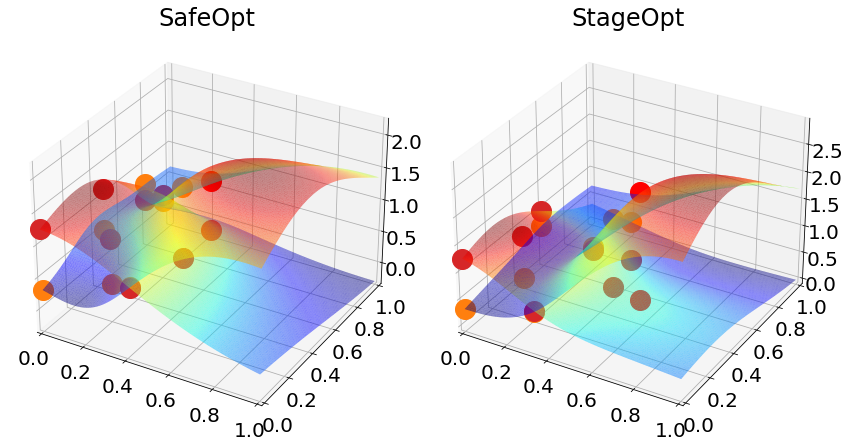

Iteration: 8
Best reward: SafeOpt: 2.286622077117226, StageOpt: 2.8482732952733585
Regret: SafeOpt: 0.7817983788198042, StageOpt: 0.22014716066367157


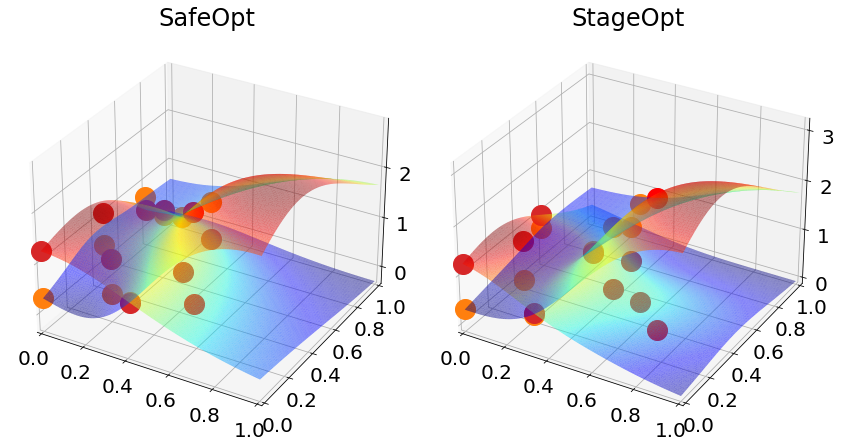

Iteration: 9
Best reward: SafeOpt: 2.28823269157272, StageOpt: 2.897387902881877
Regret: SafeOpt: 0.7801877643643103, StageOpt: 0.17103255305515308


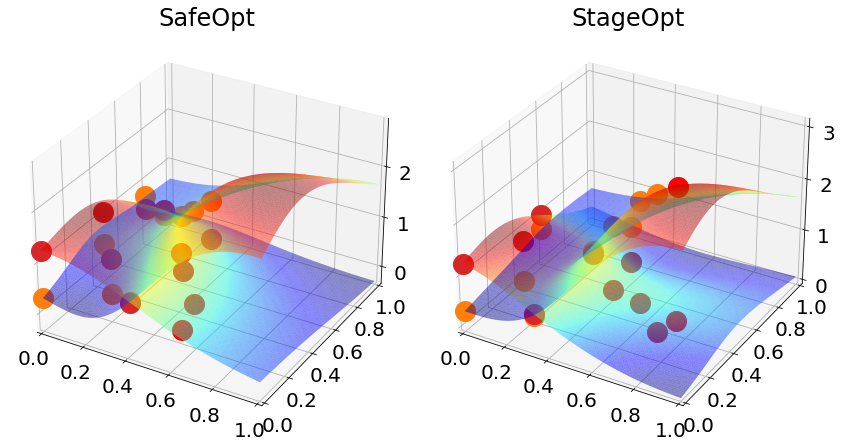

Iteration: 10
Best reward: SafeOpt: 2.2877156888146972, StageOpt: 2.9268726971256176
Regret: SafeOpt: 0.7807047671223328, StageOpt: 0.14154775881141246


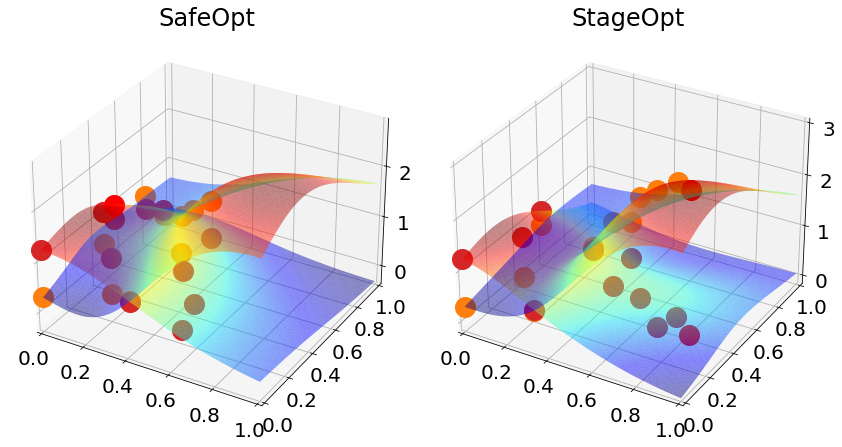

In [6]:
for i in range(10):
    # Obtain next query point
    x_next = safe_opt.optimize()
    # Get a measurement from the real system
    y_meas = fun(x_next)
    # Add this to the GP model
    safe_opt.add_new_data_point(x_next, y_meas)

    x_next = stage_opt.optimize()[0]
    y_meas = fun(x_next)
    stage_opt.add_new_data_point(x_next, y_meas)
    
    print("Iteration:", i + 1)
    print(f"Best reward: SafeOpt: {safe_opt.get_maximum()[1]}, StageOpt: {stage_opt.get_maximum()[1]}")
    print(f"Regret: SafeOpt: {safe_max_utility - safe_opt.get_maximum()[1]}, StageOpt: {safe_max_utility - stage_opt.get_maximum()[1]}")
    plot_gp()